In [1]:
%load_ext autoreload
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter

from matplotlib import rcParams
rcParams['figure.figsize'] = 16, 12
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']

In [2]:
# Custom Code Import
%autoreload 2
from fooof.fooof import *

### Functions in dev / New funcs

In [3]:
def group_three(vec):
    """Takes array of inputs, groups by three."""
    
    return [list(vec[i:i+3]) for i in range(0, len(vec), 3)]

In [4]:
def rmse(preds, target):
    """Calculate root mean squared error."""
    
    return np.sqrt(((preds - target) ** 2).mean())

In [5]:
def abs_err_freq(preds, target):
    """Calculate the absolute error across frequencies."""
    
    return np.abs(preds - target)

## MEG Data

In [6]:
from om.core.db import OMDB
from om.core.io import load_meg_psds

In [7]:
# Get database and path details from OMDB class
db = OMDB()
# Check available subject numbers for PSD files
sub_nums = db.check_dat_files('PSD')


Number of Subjects available: 103

Subject numbers with FOOF data available: 
[111802, 124340, 195121, 215187, 218131, 220216, 245518, 265922, 320548, 339964, 369737, 386068, 390845, 403435, 405716, 431088, 504997, 548027, 559176, 604600, 704718, 704814, 719634, 756575, 978341, 100307, 102816, 105923, 106521, 109123, 111514, 112920, 113922, 116524, 116726, 140117, 146129, 153732, 154532, 156334, 158136, 162026, 162935, 164636, 166438, 172029, 174841, 175237, 175540, 181232, 185442, 187547, 189349, 191033, 191437, 191841, 192641, 195041, 198653, 204521, 205119, 212318, 212823, 214524, 221319, 223929, 233326, 248339, 250427, 255639, 257845, 283543, 293748, 352132, 352738, 353740, 358144, 406836, 433839, 512835, 555348, 559053, 568963, 581450, 599671, 601127, 660951, 662551, 665254, 667056, 706040, 707749, 715950, 725751, 735148, 783462, 814649, 877168, 891667, 898176, 912447, 917255, 990366]



In [8]:
# Get PSD files
psd_files, _ = db.check_dat_files('PSD', verbose=False)

In [9]:
# Load MEG Data
subj = 352132
psd, freqs = load_meg_psds('HCP', db.psd_path, subj)

In [10]:
# OR: load MEG data from npy file

#dat = np.load('meg_dat.npy')
#freqs = dat[0]
#psd = dat[1]

In [127]:
# Set which PSD to run
cur_psd = psd[4299, :]

In [128]:
# Fix up PSD
psd_array = np.log10(cur_psd)
psd_array = np.vstack((psd_array, psd_array))
psd_array = psd_array.T

In [129]:
# FOOOF SETTINGS
window_around_max = 3
number_of_gaussians = 6
cut_freqs = [3, 40]

In [130]:
# Run FOOOF
p_flat_real, frequency_vector, trimmed_psd, psd_fit, background_fit, gaussian_fit, background_params, oscillation_params = \
    fooof(freqs, psd_array, cut_freqs, number_of_gaussians, window_around_max)

In [131]:
while np.argmax(abs_err_freq(psd_fit, trimmed_psd)) == 0:
    
    # Update cut_freqs
    cut_freqs[0] += 0.5
    
    # Re-run FOOOF
    p_flat_real, frequency_vector, trimmed_psd, psd_fit, background_fit, gaussian_fit, background_params, oscillation_params = \
        fooof(freqs, psd_array, cut_freqs, number_of_gaussians, window_around_max)
    
    print('Max error at f_low.')
    print('\t RMSE is at: ', rmse(psd_fit, trimmed_psd))
    print('\tUpdating f_low to: ', cut_freqs[0])

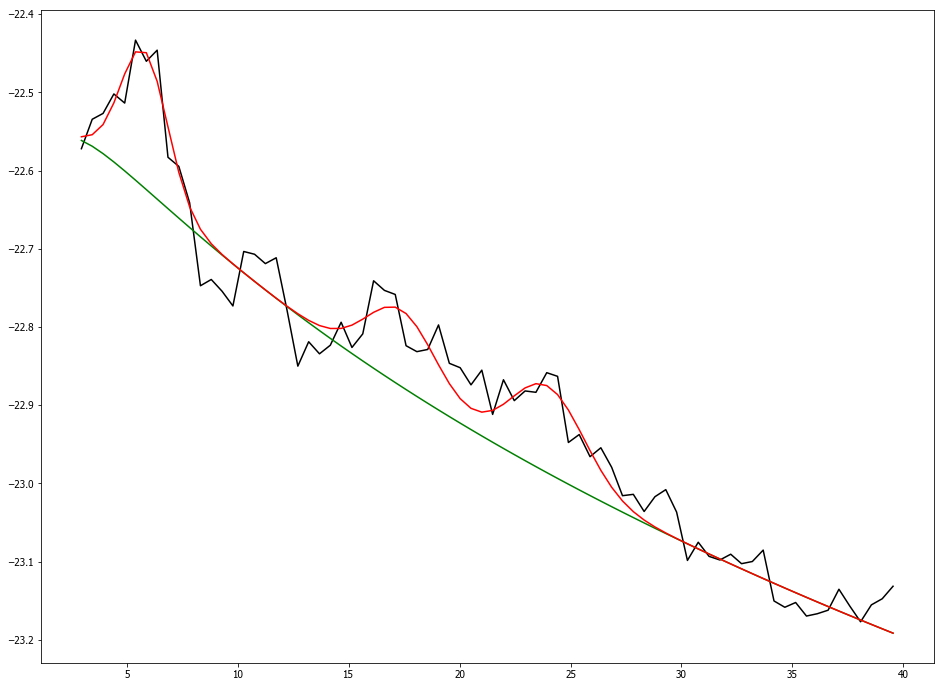

In [132]:
# Plot initial fit
plt.plot(frequency_vector, trimmed_psd, 'k')
plt.plot(frequency_vector, background_fit, 'g')
plt.plot(frequency_vector, psd_fit, 'r')

In [133]:
# Check RMSE of initial fit
rmse_orig = rmse(psd_fit, trimmed_psd)
print(rmse_orig)

0.030067218822


In [134]:
# Optimize FOOOF
guess = oscillation_params
guess = sorted(guess, key=itemgetter(1), reverse=True)

if guess:
    popt, _ = curve_fit(gaussian_function, frequency_vector, p_flat_real, p0=guess, maxfev=5000)
    multi_fit = gaussian_function(frequency_vector, *popt)
    psd_fit = multi_fit + background_fit

else:
    print('Cant optimize empty oscillation parameters')

In [135]:
print('Background:', background_params, '\n')
print('Original Oscillations:')
for ll in sorted(oscillation_params): print(ll)
print('\nOptimized Oscillations: ')
for ll in sorted(group_three(popt)): print(ll)

Background: [-22.6147725    0.31021613  -0.42034573] 

Original Oscillations:
[5.7625382805963223, 0.17579367591921269, 1.4891266477513683]
[17.371610926262395, 0.097952165081698586, 2.2444596962809582]
[23.95708920679678, 0.11126859353524769, 2.3653620071269152]

Optimized Oscillations: 
[5.7612266153338725, 0.17581147926643212, 1.4860668339299199]
[16.574201296897943, 0.088257680605310168, 0.77233419956158567]
[22.432808631134563, 0.087145023963451432, 6.3184866223437393]


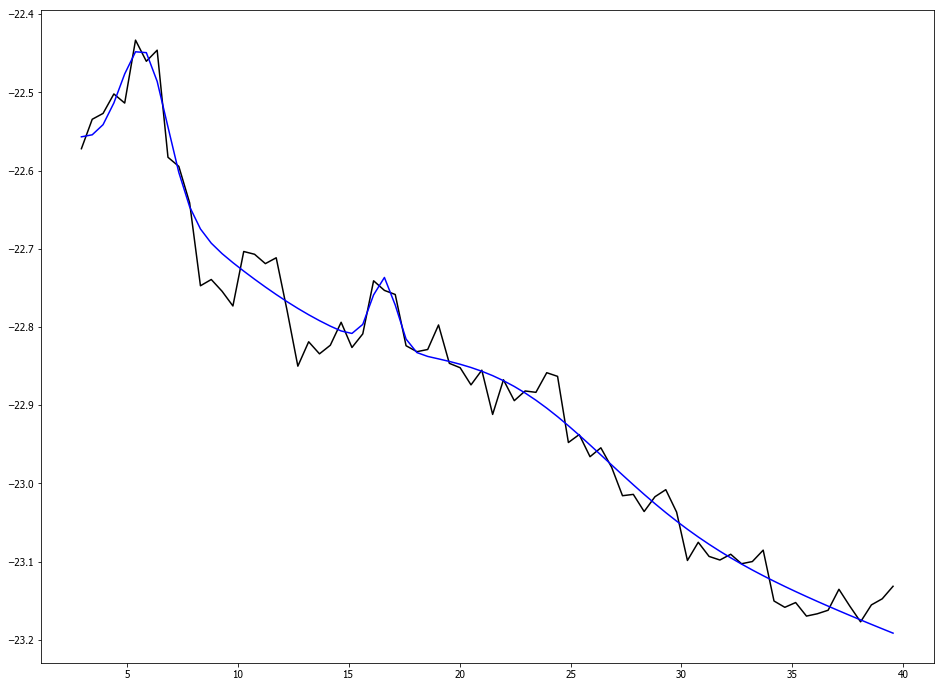

In [136]:
# Plot FOOOF Fits - after optimization
plt.plot(frequency_vector, trimmed_psd, 'k')
plt.plot(frequency_vector, psd_fit, 'b')
plt.show()

In [137]:
# Check errors after optimization
rmse_opt = rmse(psd_fit, trimmed_psd)
print(rmse_opt)

0.0279964959798


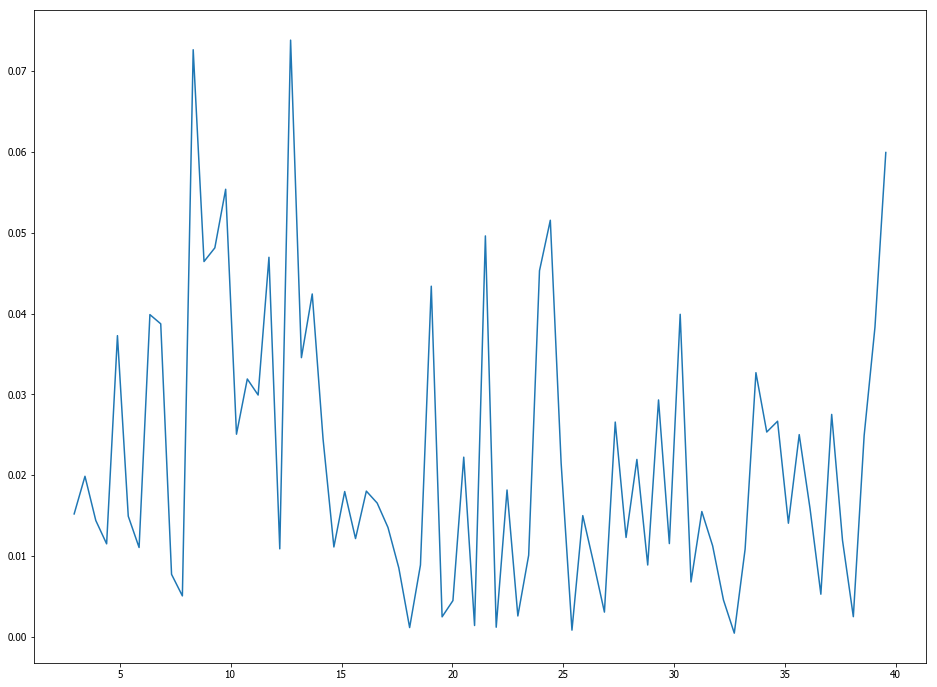

In [138]:
# Check error per frequency
abs_ef = abs_err_freq(psd_fit, trimmed_psd)
plt.plot(frequency_vector, abs_ef)

In [139]:
# Compare RMSEs
print(rmse_orig)
print(rmse_opt)

0.030067218822
0.0279964959798


### EEG Data

In [ ]:
# Load
dat = np.load('data-for-tom.npy').item()

# Get freqs & unembed from being an array of arrays
freqs = dat['f']
freqs = np.array([f[0] for f in freqs])

In [ ]:
# Grab psd of interest
psd = dat[0][20]['eyeso']

In [ ]:
psd_array = np.log10(psd)
psd_array = np.vstack((psd_array, psd_array))
psd_array = psd_array.T

In [ ]:
# FOOOF SETTINGS
window_around_max = 3
number_of_gaussians = 6
cut_freqs = [3, 40]

In [ ]:
# Run FOOOF
p_flat_real, frequency_vector, trimmed_psd, psd_fit, background_fit, gaussian_fit, background_params, oscillation_params = \
    fooof(freqs, psd_array, cut_freqs, number_of_gaussians, window_around_max)

In [ ]:
# Optimize FOOOF
guess = oscillation_params
guess = sorted(guess, key=itemgetter(1), reverse=True)

popt, _ = curve_fit(gaussian_function, frequency_vector, p_flat_real, p0=guess, maxfev=5000)
multi_fit = gaussian_function(frequency_vector, *popt)

In [ ]:
print(background_params, '\n')
for ll in oscillation_params: print(ll)
print('\n')
print(popt)

In [ ]:
# Plot FOOOF Fits
plt.plot(frequency_vector, trimmed_psd, 'k')
plt.plot(frequency_vector, psd_fit, 'r')
plt.plot(frequency_vector, multi_fit+background_fit, 'b')
plt.show()